# Movie Posters Project

Collaborators:
* Boglárka Balogh
* Emese Hunyady
* Lászlo Mocsáry
* Peter Ivanov

# Introduction

[TMDB](https://www.themoviedb.org/) is an open movie database, which assigns at least one, but often multiple genres to a movie.  
For example, _The Matrix Reloaded_ is filed under "Action", "Thriller" and "Science Fiction".

__The task for our machine learning model is to predict these genres from the movie poster alone.__

Detecting movie genres is a _Multi-Label Classification_ problem.

After understanding the concepts, set up your training and evaluation:

- determine an appropriate encoding of your target variable
- pick an appropriate loss function for training
- pick one or several additional performance metrics that you want to track during training

# Python imports

In [ ]:
import pandas as pd
import numpy as np
import tmdbsimple as tmdb
import requests as re
import json
import time
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import os

from tqdm import tqdm
from PIL import Image
from sys import getsizeof

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

from sklearn.metrics import classification_report, roc_curve, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score

# Data Collection

We acquired the necessary API key for accessing the TMDB API.

To access the API, we're using standard _requests_ package and site-specific _tmdbsimple_ package which simplifies the whole thing.

In [ ]:
# Some settings for the tmdbsimple package

# Setting 5 seconds as timeout for both connect and read
tmdb.REQUESTS_TIMEOUT = 5
tmdb.REQUESTS_SESSION = re.Session()

In [ ]:
# Here we store our API key
tmdb.API_KEY = "e62bfeb02f260b4edb20351ea355867d"

# API url
api_url = "https://api.themoviedb.org/3/"

Let's test how we can get the poster file. In order to generate a fully working image URL, we'll need 3 pieces of data. Those pieces are a `base_url`, a `file_size` and a `file_path`.

The first two pieces can be retrieved by calling the API:

`https://api.themoviedb.org/3/configuration?api_key=e62bfeb02f260b4edb20351ea355867d`

We can see the content below:

In [ ]:
# We need to get some stuff from configuration at the beginning:

# Composing the request URL
url = api_url + "configuration" + "?" + "api_key=" + tmdb.API_KEY

# Getting response to our GET request
response = re.get(url)

# Storing the response content as JSON
content_json = json.loads(response.content)

content_json

{'images': {'base_url': 'http://image.tmdb.org/t/p/',
  'secure_base_url': 'https://image.tmdb.org/t/p/',
  'backdrop_sizes': ['w300', 'w780', 'w1280', 'original'],
  'logo_sizes': ['w45', 'w92', 'w154', 'w185', 'w300', 'w500', 'original'],
  'poster_sizes': ['w92', 'w154', 'w185', 'w342', 'w500', 'w780', 'original'],
  'profile_sizes': ['w45', 'w185', 'h632', 'original'],
  'still_sizes': ['w92', 'w185', 'w300', 'original']},
 'change_keys': ['adult',
  'air_date',
  'also_known_as',
  'alternative_titles',
  'biography',
  'birthday',
  'budget',
  'cast',
  'certifications',
  'character_names',
  'created_by',
  'crew',
  'deathday',
  'episode',
  'episode_number',
  'episode_run_time',
  'freebase_id',
  'freebase_mid',
  'general',
  'genres',
  'guest_stars',
  'homepage',
  'images',
  'imdb_id',
  'languages',
  'name',
  'network',
  'origin_country',
  'original_name',
  'original_title',
  'overview',
  'parts',
  'place_of_birth',
  'plot_keywords',
  'production_code',
 

Now we can set up the code to get these pieces automatically:

In [ ]:
# We need base_url
base_url = content_json["images"]["base_url"]

# We need some poster_size
poster_sizes = content_json["images"]["poster_sizes"]

# Right now there are following poster sizes available:
# ['w92', 'w154', 'w185', 'w342', 'w500', 'w780', 'original']

# We pick 'w185` as a start
poster_size = poster_sizes[2]

In [ ]:
poster_size

'w185'

Now we will try to get the poster path from the movie information which we get from the API via `tmdbsimple` tool.

In [ ]:
# We need poster_path, which we get from the movie response
movie = tmdb.Movies(603) # This is Matrix
movie_info = movie.info()

# Getting the poster path
poster_path = movie_info["poster_path"]

# Getting the movie genres
genres = movie_info["genres"]

# Getting the movie title
title = movie_info["original_title"]

# Compose the poster URL
poster_url = base_url + poster_size + poster_path

print(f"Movie title = {title}")
print(f"Genres      = {genres}")
print(f"Poster URL  = {poster_url}")


Movie title = The Matrix
Genres      = [{'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]
Poster URL  = http://image.tmdb.org/t/p/w185/f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg


Now let's make a function to get the movie details:
- movie original title
- list of genres
- poster file URL

Given:
- movie ID
- poster file size (with default value)

In [ ]:
# Function to get movie title, genres and poster path
#  - given the movie_id

def get_movie(movie_id, poster_size="w92"):
  """ Get movie title, genres and poster path

  movie_id    - TMDB.org internal movie_id
  poster_size - size of poster. Default = 'w92'.
                Can be one of following:
                  - ['w92',
                      'w154',
                      'w185',
                      'w342',
                      'w500',
                      'w780',
                      'original']
  """

  # Get movie object
  movie      = tmdb.Movies(movie_id)
  movie_info = movie.info()
  
  # Get title, genres, poster_path
  title      = movie_info["original_title"]
  genres     = [genre["name"] for genre in movie_info["genres"]]
  path       = movie_info["poster_path"]

  # Compose poster file URL
  try:
    poster = base_url + poster_size + path
  except:
    poster = "no poster!!!"

  movie_dict = {"title": title, "genres": genres, "poster": poster}
  
  return movie_dict

In [ ]:
# Test the fuction a selection of ids:

for movie_id in [597, 603, 607, 703]:
    movie_dict = get_movie(movie_id, poster_size)

    print(f"-------------")
    print(f"Movie title = {movie_dict['title']}")
    print(f"Genres      = {movie_dict['genres']}")
    print(f"Poster URL  = {movie_dict['poster']}")

-------------
Movie title = Titanic
Genres      = ['Drama', 'Romance']
Poster URL  = http://image.tmdb.org/t/p/w185/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg
-------------
Movie title = The Matrix
Genres      = ['Action', 'Science Fiction']
Poster URL  = http://image.tmdb.org/t/p/w185/f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg
-------------
Movie title = Men in Black
Genres      = ['Action', 'Adventure', 'Comedy', 'Science Fiction']
Poster URL  = http://image.tmdb.org/t/p/w185/uLOmOF5IzWoyrgIF5MfUnh5pa1X.jpg
-------------
Movie title = Annie Hall
Genres      = ['Comedy', 'Drama', 'Romance']
Poster URL  = http://image.tmdb.org/t/p/w185/gBo4G0p8iVS998aYvXS656jbsH2.jpg


Now we have to make a list of IDs.

For a start, let's take first 10.000 movies from the daily export file. This file can be retrieved from the site by using this tool: [Daily File Exports](https://developers.themoviedb.org/3/getting-started/daily-file-exports).

We downloaded and extracted file `movie_ids_12_05_2021.json.gz` and now we will process first 10.000 movies from it. 



In [ ]:
# Set up file
with open("movie_ids_12_05_2021.json", "rt") as file:

    # create empty movie_ids list
    movie_ids = []

    # read line-by-line
    for line in tqdm(file, desc="Loading file..."):
        movie = json.loads(line)
        movie_ids.append(movie["id"])

    # close file    
    file.close()

Loading file...: 661125it [00:05, 120605.71it/s]


In [ ]:
# We have now 661125 movie ids in a list
len(movie_ids)

661125

In [ ]:
movie_ids[0:5]

[3924, 6124, 8773, 25449, 31975]

Now we have 661125 movie IDs loaded into a list called `movie_ids`.

Using the list of movie IDs, following block will download all the information about movies into one huge dataframe.

It is now commented out, so there's no accidental execution. The entire run takes __1 hour 20 minutes__. 

In [ ]:
# # Some limiting settings
# limit         = 100000
# batch_size    = 500
# pause         = 2

# # Initialization of counters
# movie_dict    = {}
# movie_count   = 0
# index         = -1
# batch         = -1
# batch_counter = 0

# # To get information about the speed, following timestamps are collected
# start_time = time.ctime()
# start = time.perf_counter()

# print(f"Movie retrieval started: {start_time}")

# # Main loop
# while movie_count < limit:
#     index += 1

#     if batch < batch_size:
#         batch += 1
#     else:
#         batch = 0
#         batch_counter += 1
#         now = time.perf_counter()
#         print(f"Batch {batch_counter} completed. Movies fetched: {movie_count}. Elapsed time: {now - start}")
#         time.sleep(pause)

#     movie_id = movie_ids[index]

#     # We try to get and update the dictionary with next movie
#     try:
#         movie_dict.update({movie_id: get_movie(movie_id, poster_size)})
#         movie_count += 1
#         #print(f"-------------")
#         #print(f"Movie title = {movie_dict[movie_id]['title']}")
#         #print(f"Genres      = {movie_dict[movie_id]['genres']}")
#         #print(f"Poster URL  = {movie_dict[movie_id]['poster']}")        
#     except:
#         continue

In [ ]:
# len(movie_dict)

In [ ]:
# df_movies = pd.DataFrame.from_dict(movie_dict, orient="index")

In [ ]:
# df_movies.to_csv("df_movies.csv")

# Checkpoint 1

In [ ]:
df_movies = pd.read_csv("df_movies.csv", index_col=0)

In [ ]:
# there are movies without poster url!!!
df_movies[df_movies['poster']== "no poster!!!"].count()

title     18158
genres    18158
poster    18158
dtype: int64

In [ ]:
# there are also movies without any genre!!!
df_movies['genres'].value_counts()

[]                                                                                    12129
['Drama']                                                                              9896
['Comedy']                                                                             8966
['Documentary']                                                                        6597
['Music']                                                                              3090
                                                                                      ...  
['Adventure', 'Fantasy', 'Drama', 'Action', 'Comedy', 'Science Fiction', 'Family']        1
['Adventure', 'Action', 'History']                                                        1
['Mystery', 'Comedy', 'TV Movie']                                                         1
['Comedy', 'Thriller', 'Romance', 'Drama', 'Crime']                                       1
['Crime', 'Drama', 'Thriller', 'Horror', 'Mystery']                             

In [ ]:
# calculate the number of movies which have at least one genre AND a poster url

df_movies[df_movies['poster']!= "no poster!!!"][df_movies['genres']!='[]'].count()

/shared-libs/python3.6/py-core/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


title     76979
genres    76979
poster    76979
dtype: int64

In [ ]:
# collect those movies in a separate data frame
df_posters = df_movies[df_movies['poster']!= "no poster!!!"].copy()
df_posters = df_posters[df_posters['genres']!='[]']

In [ ]:
df_posters.shape

(76979, 3)

So we got ourselves a nice bunch of movies (76979) with URLs to their posters and their genre information. 

# Truth labels

In [ ]:
# get the id's and the names of all possible genres from the data base

path1 = f"https://api.themoviedb.org/3/genre/movie/list?api_key={tmdb.API_KEY}&language=en-US"

df_all_genres = pd.read_json(path1)
df_all_genres = df_all_genres['genres'].apply(pd.Series)
df_all_genres = pd.DataFrame(df_all_genres.set_index('name')).sort_index()
df_all_genres.T

# there are 19 different genres!

name,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,28,12,16,35,80,99,18,10751,14,36,27,10402,9648,10749,878,10770,53,10752,37


In [ ]:
genres_list = list(df_all_genres.index)

print(genres_list)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


In [ ]:
# This is stupid simple way how to create one-hot encoding
# Stupid --> Brilliant (comment by László)

for genre in genres_list:
    df_posters[genre] = 0
    df_posters.loc[df_posters["genres"].str.contains(genre), genre] = 1

In [ ]:
df_posters.head(10)

,title,genres,poster,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
3924,Blondie,['Comedy'],http://image.tmdb.org/t/p/w185/o6UMTE2LzQdlKVx...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6124,Der Mann ohne Namen,['Adventure'],http://image.tmdb.org/t/p/w185/6xUbUCvndklbGVY...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8773,L'amour à vingt ans,"['Drama', 'Romance']",http://image.tmdb.org/t/p/w185/aup2QCYCsyEeQfp...,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
31975,Sesame Street: Elmo Loves You!,['Family'],http://image.tmdb.org/t/p/w185/qKWcCmvGr4g0dgX...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ariel,"['Drama', 'Crime', 'Comedy']",http://image.tmdb.org/t/p/w185/ojDg0PGvs6R9xYF...,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Varjoja paratiisissa,"['Drama', 'Comedy']",http://image.tmdb.org/t/p/w185/nj01hspawPof0mJ...,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Four Rooms,"['Crime', 'Comedy']",http://image.tmdb.org/t/p/w185/75aHn1NOYXh4M7L...,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Judgment Night,"['Action', 'Thriller', 'Crime']",http://image.tmdb.org/t/p/w185/rYFAvSPlQUCebay...,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8,Life in Loops (A Megacities RMX),['Documentary'],http://image.tmdb.org/t/p/w185/x7Sz339F2oC8mBf...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11,Star Wars,"['Adventure', 'Action', 'Science Fiction']",http://image.tmdb.org/t/p/w185/6FfCtAuVAW8XJjZ...,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# save df_posters to file 

# df_posters.to_csv("df_posters.csv")

In [ ]:
# restore df_posters from saved file

df_posters = pd.read_csv("df_posters.csv", index_col=0)

In [ ]:
df_posters.shape

(76979, 22)

# Getting posters

Now it'd be good to set up a function to download the poster image from the internet and store it to specific file.
We'll use it in a loop.

In [ ]:
def download_poster(movie_id, url, folder="data/"):
    file_name = folder + str(movie_id) + ".jpg"
    f = open(file_name, "wb")
    try:
        response = re.get(url)
        f.write(response.content)
    except:
        print(f"Failed to get or save poster for movie_id = {movie_id}")
    f.close()

In [ ]:
# A test:
download_poster(6, "http://image.tmdb.org/t/p/w185/rYFAvSPlQUCebayLcxyK79yvtvV.jpg")

Now let's get ALL the posters. We added `tqdm`, which will display nice progressbar and estimated time:

In [ ]:
# Getting ALL the posters:
for index, url in tqdm(zip(df_posters.index, df_posters["poster"]), total=df_posters.shape[0], ncols=150):
    download_poster(index, url)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 76979/76979 [17:49<00:00, 72.01it/s]


Now we have a bunch of posters.

This is how we can display and also convert the image to a numpy 3-dim array as we need for NN training purposes 😊

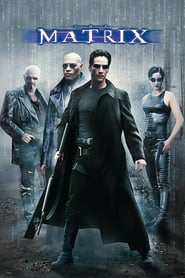

In [ ]:
image = Image.open("data/603.jpg")
image_data = np.asarray(image, dtype=np.uint8)
image.show()

In [ ]:
image_data.shape

(278, 185, 3)

In [ ]:
for movie_id in df_posters.index:
    image = Image.open("data/"+ str(movie_id) + ".jpg")
    if image.size[1] < 278:
        image = image.resize((185, 278))
    elif image.size[1] > 278:
        image = image.resize((185,278), resample=PIL.Image.LANCZOS)

## Resizing posters

Now we'd like to check whether all the images have same width and height:

In [ ]:
ws = []
hs = []

for index in tqdm(df_posters.index):
    try:
        image = Image.open("data/" + str(index) + ".jpg")
        width, height = image.size
        ws.append(width)
        hs.append(height)
    except Exception as e:
        print(e)
        continue



100%|██████████| 76979/76979 [01:53<00:00, 675.46it/s]


In [ ]:
np.max(hs), np.min(hs), np.mean(hs), np.median(hs)

(278, 278, 278.0, 278.0)

In [ ]:
np.max(ws), np.min(ws), np.mean(ws)

(185, 185, 185.0)

We found that the posters have same width, but different heights. We need to make them to be of equal size.

Let's find the optimal size by checking which size is prevalent in our data set.

In [ ]:
hs = np.asarray(hs)

In [ ]:
np.unique(hs, return_counts=True)

(array([242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
        255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
        268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
        281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
        294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
        307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
        320, 321, 322, 323, 324, 325, 328, 329, 330, 331, 332, 333, 334,
        335, 336, 337, 338, 340, 341, 342, 344, 345, 348, 350, 351, 352,
        354, 355, 362, 365, 366, 369, 370, 383, 397, 401, 402, 478]),
 array([   10,    13,    17,    62,   172,  1535,   109,   105,   111,
          154,   137,    94,   116,    85,   171,   202,   222,   540,
          627,  1084,  1252,   941,  1352,   631,   396,   366,   234,
          209,   167,   296,   873,   318,   604,   506,   430,  3762,
        56771,   307,   337,   315,   282,   108,    90,    85

In [ ]:
np.unique(hs, return_counts=True)[0][36]

278

In [ ]:
np.unique(hs==278, return_counts=True)

(array([False,  True]), array([20207, 56771]))

(array([4.0000e+01, 2.3400e+02, 1.7490e+03, 2.6500e+02, 2.3100e+02,
        3.7200e+02, 4.2400e+02, 1.1670e+03, 3.2770e+03, 1.9830e+03,
        7.6200e+02, 6.1000e+02, 1.1690e+03, 1.4280e+03, 4.1920e+03,
        5.7078e+04, 9.3400e+02, 1.9800e+02, 1.6700e+02, 1.4400e+02,
        7.3000e+01, 4.5000e+01, 6.0000e+01, 2.6000e+01, 1.6000e+01,
        2.3000e+01, 4.0000e+00, 1.6000e+01, 1.4000e+01, 4.0000e+00,
        1.2000e+01, 1.4000e+01, 6.0000e+00, 1.0000e+01, 7.0000e+00,
        4.0000e+00, 1.1000e+01, 3.0000e+00, 1.5000e+01, 1.5000e+01,
        5.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 1.4600e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

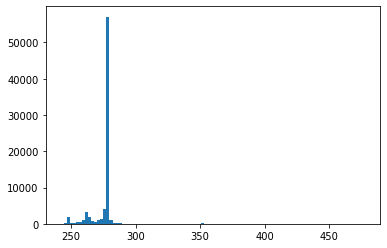

In [ ]:
plt.hist(hs, bins=100)

We found out that all images has `width = 185` and various height. We need to make all images to same size.

Let's resize with following strategy:
 - if the height < 278 -> simple rescale (no resampling)
 - if the height = 278 -> do nothing (the majority of images are here)
 - if the height > 278 -> rescale with resampling

In [ ]:
# Rescaling code

for file_name in tqdm(os.listdir("data/")):
    try:
        image_file = "data/" + file_name
        image = Image.open(image_file)
        width, height = image.size
        #print(f"{file_name} {width}x{height}")

        if height < 278:
            # upscaling with pasting
            newimage = Image.new(image.mode, (width, 278)) 
            newimage.paste(image, None)
            newimage.save(image_file)
            #print(f"Upscaled.")
        
        elif height > 278:
            # resampling using LANCZOS
            image = image.resize((width, 278), resample=PIL.Image.LANCZOS) 
            image.save(image_file)
            #print(f"Downscaled.")
      
    except Exception as e:
        print(e)
        continue

100%|██████████| 81842/81842 [04:03<00:00, 336.11it/s]


In [ ]:
df_posters.loc[[67013]]  # this image had some error before

,title,genres,poster,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
67013,Emmerson Nogueira – Ao Vivo,['Music'],http://image.tmdb.org/t/p/w185/qEsHYRtYPDG8ozo...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


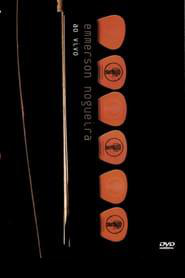

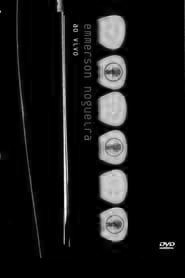

In [ ]:
# try it again after reloading the file (it has been done manually)
problem_image = Image.open("data/67013.jpg")
problem_image.show()
problem_image.size
problem_image.getchannel(0)

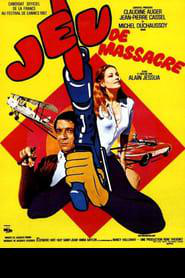

(185, 278)

In [ ]:
upscaled_image = Image.open("data/78815.jpg")
upscaled_image.show()
upscaled_image.size

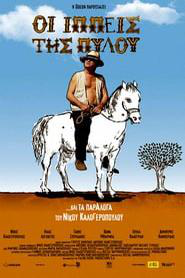

(185, 278)

In [ ]:
downscaled_image = Image.open("data/80645.jpg")
#downscaled_image = Image.open("data/104438.jpg")
downscaled_image.show()
downscaled_image.size

So right now we should have all files in the `data` directory in the same image size:

In [ ]:
ws = []
hs = []

for file_name in tqdm(os.listdir("data/")):
    try:
        image = Image.open("data/" + file_name)
        width, height = image.size
        ws.append(width)
        hs.append(height)
    except Exception as e:
        print(e)
        continue

100%|██████████| 81842/81842 [01:31<00:00, 892.16it/s]


In [ ]:
max(hs), min(hs), max(ws), min(ws)

(278, 278, 185, 185)

In [ ]:
df_posters.shape

(76979, 22)

# Prepare final data frame

Right now we've got $76979$ movie records that:
 - have poster available (185px x 278px)
 - have at least one genre assigned

 We can link the posters with movie genres using file name which contains `movie_id`.

In [ ]:
# shuffling - maybe not necessary but surely no harmful before train - test split
df_posters = df_posters.sample(frac=1)

# we can always reorder the dataframe by:
# df_posters.sort_index()

df_posters.head()

,title,genres,poster,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
13459,Barbie in 'A Christmas Carol',"['Animation', 'Family']",http://image.tmdb.org/t/p/w185/fX9g1AE1JIqjX3L...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109729,The Canyons,"['Thriller', 'Drama']",http://image.tmdb.org/t/p/w185/ldJ4D536uoJ8ayF...,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
56994,La seconda notte di nozze,"['Drama', 'Comedy']",http://image.tmdb.org/t/p/w185/4aKBfKRRYdScWzx...,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
28989,Across the Great Divide,"['Action', 'Drama', 'Family']",http://image.tmdb.org/t/p/w185/g1w0n8mW9SrzpYZ...,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
88798,Something Short of Paradise,"['Drama', 'Comedy', 'Romance']",http://image.tmdb.org/t/p/w185/1etSVKQ05z3LBsf...,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
data = df_posters.drop(['title', 'genres', 'poster'], axis=1).copy()

In [ ]:
data = data.reset_index()

In [ ]:
data.rename(columns={"index":"id"}, inplace=True)

In [ ]:
# this is our final data frame with all the downloaded movies/posters, shuffled

data

,id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,13459,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,109729,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,56994,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,28989,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,88798,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76974,89645,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
76975,56330,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
76976,9804,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
76977,50799,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# store it as a.csv file (only once)

# data.to_csv("data.csv")

# Checkpoint 2

In [ ]:
# read final data frame from stored file
data =  pd.read_csv("data.csv", index_col=0)
data.head()

,id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,98444,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,7392,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
2,112803,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,81156,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,148168,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we want to create $X$ matrix, which contains all the images and is super huge. Maybe the DeepNote will crash 😈

## Loading X using numpy

This was an attempt to load the image data to a huge numpy ndarray. It failed because the entire dataset could take ~ 11G of memory and the loading was very slow.

In the next chapter, we'll try to use `tf.data` for this.

In [ ]:
Using numpy.insert() function in the NumPy module, we can also insert an element at the end of a numpy array.

In [ ]:
X = np.ndarray(shape=(0, 278, 185, 3), dtype=np.uint8)  
  
limit = 10000  

count = 0
for movie_id in tqdm(data["id"], total=limit):
    image = Image.open("data/" + str(movie_id) + ".jpg").convert(mode="RGB")
    #print(f"Converting {movie_id}.jpg")
    image_data = np.asarray(image, dtype=np.uint8)
    image_data = image_data.reshape(1, *(image_data.shape))
    try:
        X = np.append(X, image_data, axis=0) 
        count += 1

        if count == limit:
            break
    except Exception as e:
        print(e)
        print(movie_id)
        continue


print(f"\nSize of X = {getsizeof(X)/1024/1024} MiB.")

100%|█████████▉| 9999/10000 [25:32<00:00,  6.53it/s]
Size of X = 1471.4242401123047 MiB.



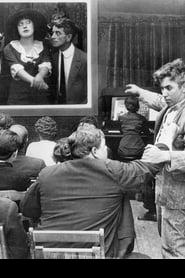

In [ ]:
# the above code first run on error with some images. The reason was that there are some B&W images among the posters
# remedy was applying the .convert(mode="RGB") method at opening the images

im = Image.open("data/132536.jpg")  # two such images in the first 500
im.show() # goddamit, it's grayscale! oh wait



In [ ]:
movie_id, image_data.shape, X.shape  # yes, here one dimension is missing from image data!  the last one

(159427, (1, 278, 185), (22, 278, 185, 3))

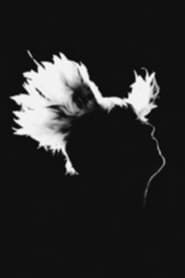

In [ ]:
# how's that possible? is it grayscale?
Image.fromarray(X[22]).show() # BAM!

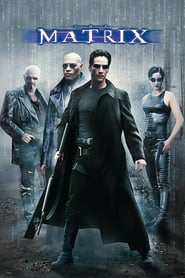

In [ ]:
image = Image.open("data/603.jpg")
image_data = np.asarray(image, dtype=np.uint8)
image.show()

In [ ]:
image_data[0]

array([[ 96, 114, 126],
       [112, 130, 142],
       [106, 124, 136],
       [107, 125, 137],
       [ 96, 114, 126],
       [103, 121, 133],
       [ 96, 114, 126],
       [107, 125, 137],
       [105, 123, 135],
       [111, 129, 141],
       [110, 128, 140],
       [103, 121, 133],
       [103, 121, 133],
       [108, 126, 138],
       [108, 126, 138],
       [103, 121, 133],
       [108, 126, 138],
       [106, 124, 136],
       [121, 139, 151],
       [110, 128, 140],
       [119, 137, 149],
       [107, 125, 137],
       [104, 122, 134],
       [109, 127, 139],
       [112, 130, 142],
       [110, 128, 140],
       [106, 124, 136],
       [103, 121, 133],
       [102, 120, 132],
       [101, 119, 131],
       [100, 118, 130],
       [100, 118, 130],
       [116, 134, 146],
       [115, 133, 145],
       [114, 132, 144],
       [109, 127, 139],
       [104, 122, 134],
       [101, 119, 131],
       [101, 119, 131],
       [103, 121, 133],
       [117, 135, 147],
       [121, 139

## Loading X using tf.data

Within this chapter we'll try to use `tf.data` to store our image data.

There are some advantages:
* the data is read in stream mode, so we shouldn't run out of memory during training

> For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

Source: [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

### Basic mechanics

To create an input pipeline, you must start with a data source. If your input data is stored in a file in the recommended `TFRecord` format, you can use `tf.data.TFRecordDataset()`.

Emese found this:  https://stackoverflow.com/questions/33849617/how-do-i-convert-a-directory-of-jpeg-images-to-tfrecords-file-in-tensorflow

From there I found this one:    https://www.tensorflow.org/guide/datasets#decoding_image_data_and_resizing_it

In [ ]:
data["id"]

0         98444
1          7392
2        112803
3         81156
4        148168
          ...  
76974    110903
76975     81678
76976      1943
76977     90530
76978    114136
Name: id, Length: 76979, dtype: int64

In [ ]:
data.columns

Index(['id', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'],
      dtype='object')

In [ ]:
genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']

In [ ]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename, genre, movie_id):

    # Reads the contents of file
    image_string = tf.io.read_file(filename)

    # Decode a JPEG-encoded image to a uint8 tensor.
    # channels=3 -> RGB (we have some grayscale images, so to enforce it)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)

    # Convert image to dtype, scaling its values if needed.
    # I don't think we need this.
    # Perhaps we could normalize to <0,1> interval
    image_converted = tf.image.convert_image_dtype(image_decoded, tf.float32)

    # Resizing is not needed, we made sure the sizes of all posters are (278, 185)
    # image_resized = tf.image.resize(image_converted, [278, 185])

    return image_converted, genre, movie_id

# `ids[i]` is the id for the movie in data
ids = data["id"]

# `labels[i]` is the vector of the genres in data
genres = data[genre_list]

# A vector of filenames.
filenames = ["data/" + str(item) + ".jpg" for item in data['id']]

# Creates a Dataset whose elements are slices of the given tensors (filenames and labels)
dataset = tf.data.Dataset.from_tensor_slices((filenames, genres, ids))

# Maps _parse_function across all elements, returns new dataset with
# transformed elements (loaded image, label)
dataset = dataset.map(_parse_function)

In [ ]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.MapDataset

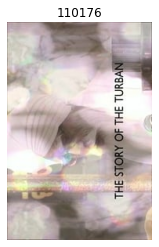

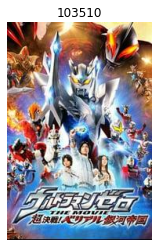

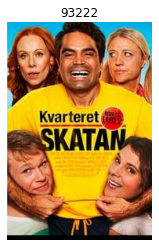

In [ ]:
def show(image, movie_id):
  plt.figure()
  plt.imshow(image)
  plt.title(movie_id.numpy())
  plt.axis('off')

for image, genres, movie_id in dataset.skip(300).take(3):
    show(image, movie_id)
  

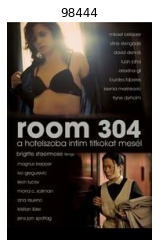

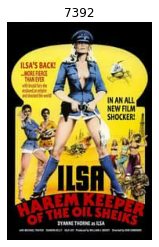

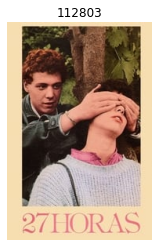

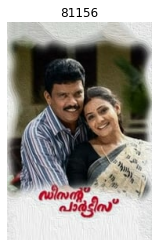

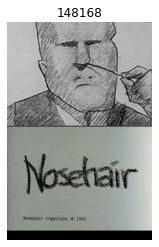

In [ ]:
iterator = iter(dataset)

for _ in range(5):
    image, genres, movie_id = iterator.get_next()
    show(image, movie_id)

In [ ]:
for image, genres, movie_id in iter(dataset.take(10)):
    print(genres.numpy())

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


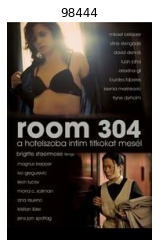

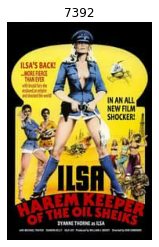

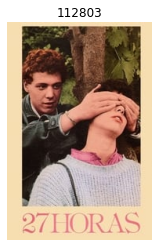

In [ ]:
for image, genres, movie_id in iter(dataset.take(3)):
    show(image, movie_id)

So right now, we have a `tf.data.Dataset` instance "loaded" with all the images, their genres and movie_ids.
So I guess we're on a right track.

Hopefully we can make a `generator` to use with CNN model.

And right now I have no idea how to split it to train and test 😅.

Perhaps we can use a function for that.

# Checkpoint 3

Run these two blocks to get everything needed set up after a hardware restart:

In [ ]:
import pandas as pd
import numpy as np
import tmdbsimple as tmdb
import requests as re
import json
import time
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import os
import pickle

from tqdm import tqdm
from PIL import Image
from sys import getsizeof

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

In [ ]:
data =  pd.read_csv("data.csv", index_col=0)
genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']

# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename, genre, movie_id):

    # Reads the contents of file
    image_string = tf.io.read_file(filename)

    # Decode a JPEG-encoded image to a uint8 tensor.
    # channels=3 -> RGB (we have some grayscale images, so to enforce it)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)

    # Convert image to dtype, scaling its values if needed.
    # I don't think we need this.
    # Perhaps we could normalize to <0,1> interval
    image_converted = tf.image.convert_image_dtype(image_decoded, tf.float32)

    # Resizing is not needed, we made sure the sizes of all posters are (278, 185)
    image_resized = tf.image.resize(image_converted, [278, 185])

    return image_resized, genre  #, movie_id

# `ids[i]` is the id for the movie in data
ids = data["id"]

# `labels[i]` is the vector of the genres in data
genres = data[genre_list].to_numpy()
# genres = genres.reshape(genres.shape[0], 1, 19)
# genres = genres.reshape(-1,19,)

# A vector of filenames.
filenames = ["data/" + str(item) + ".jpg" for item in ids]

# Creates a Dataset whose elements are slices of the given tensors (filenames and labels)
dataset = tf.data.Dataset.from_tensor_slices((filenames, genres, ids))

# Maps _parse_function across all elements, returns new dataset with
# transformed elements (loaded image, label)
full_dataset = dataset.map(_parse_function)

In [ ]:
genres.shape

(76979, 19)

In [ ]:
full_dataset

<MapDataset shapes: ((278, 185, 3), (19,)), types: (tf.float32, tf.int64)>

# Train - Test split

In [ ]:
# Length of the dataset:
DATASET_SIZE = full_dataset.__len__().numpy()

In [ ]:
# Taken from: https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets

# train_size = int(0.6 * DATASET_SIZE)
# val_size = int(0.2 * DATASET_SIZE)
# test_size = int(0.2 * DATASET_SIZE)

# full_dataset = full_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=False)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size)
# test_dataset = test_dataset.take(test_size)

In [ ]:
# Method 2

def is_test(a, b):
    return a % 5 == 0         # every 5th data goes to test set (20% of the whole set)

def is_train(a, b):
    return not is_test(a, b)  # all the rest goes to train set

def is_val(a, b):
    return a % 5 == 0         # from train set every 5th data goes to validation set (16% of the whole set)

def is_train2(a, b):
    return not is_val(a, b)   # all the rest goes to train set (64% of the whole set)


remove_index = lambda a,b: b

test_dataset = full_dataset.enumerate() \
                    .filter(is_test) \
                    .map(remove_index)

train_dataset = full_dataset.enumerate() \
                    .filter(is_train) \
                    .map(remove_index)

val_dataset   = train_dataset.enumerate() \
                    .filter(is_val) \
                    .map(remove_index)

train_dataset = train_dataset.enumerate() \
                    .filter(is_train2) \
                    .map(remove_index)

In [ ]:
# This takes 5 minutes - so not worth re-runing (with GPU ~ 1 minute)
count = 0
for _ in tqdm(train_dataset):
    count += 1

print(count)

49266it [01:35, 516.39it/s]49266



In [ ]:
# This takes 3 minutes, with GPU it takes less than a minute!
count = 0
for _ in tqdm(test_dataset):
    count += 1

print(count)

15396it [00:43, 352.65it/s]15396



In [ ]:
# This takes 3 minutes, with GPU it takes less than a minute!
count = 0
for _ in tqdm(val_dataset):
    count += 1

print(count)

12317it [00:41, 295.61it/s]12317



In [ ]:
tr= 49266
tst= 15396
val= 12317
tot = tr+tst+val

print(tot, 100*tr/tot, 100*tst/tot, 100*val/tot, tr)

76979 63.99927252887151 20.000259811117317 16.00046766001117 49266


In [ ]:
element = train_dataset.take(1)

In [ ]:
train_dataset

<MapDataset shapes: ((278, 185, 3), (19,), ()), types: (tf.float32, tf.int64, tf.int64)>

This block crashes the hardware not anymore:

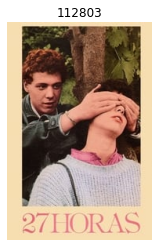

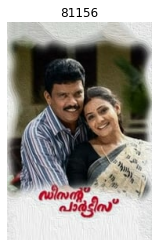

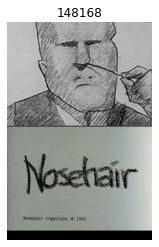

In [ ]:
def show(image, movie_id):
  plt.figure()
  plt.imshow(image)
  plt.title(movie_id.numpy())
  plt.axis('off')

for image, genres, movie_id in train_dataset.take(3):
    show(image, movie_id)

# CNN

Now we're in position to create an architecture to our convolutional neural network (CNN).

We'll be working in RGB space, that is 3 separate channels per each pixel, which makes it a 3D tensor. So we'll use following layer types:
 - Conv3D
 - MaxPooling3D - we can also use Average, but Max will indicate a presence of feature in the feature map better
 - Flatten - we need to flatten the output before the final fully-connected Dense part
 - Dense

The image size is currently $

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPool2D, Flatten, Dense


model = Sequential()
model.add(Conv2D(input_shape=(278,185,3),filters=64,kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=8,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
#model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=19, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 278, 185, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 278, 185, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 139, 92, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 139, 92, 32)       18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 69, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 46, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 23, 16)        0

In [ ]:
model1 = Sequential()
model1.add(Conv2D(input_shape=(278,185,3),filters=64,kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Flatten())
model1.add(Dense(units=128, activation="relu"))
model1.add(Dense(units=19, activation="sigmoid"))

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 278, 185, 64)      1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 278, 185, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 139, 92, 64)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 139, 92, 32)       18464     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 139, 92, 32)       9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 69, 46, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 69, 46, 32)       

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.binary_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["acc"])

In [ ]:
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split)

#train_generator = datagen.flow(train_images, y=train_labels)
#test_generator  = datagen.flow(test_images, y=test_labels)

In [ ]:
# def get_image(image,labels,movie_id):
#     return image

# def get_labels(image,labels,movie_id):
#     return labels

# X_train = train_dataset.map(get_image)
# y_train = train_dataset.map(get_labels)

# X_test = test_dataset.map(get_image)
# y_test = test_dataset.map(get_labels)

In [ ]:
epochs=10
batch_size=63*2
val_batch_size = 32

history = model.fit(
                    train_dataset.repeat().batch(batch_size),
                    epochs=epochs,
                    verbose=1,
                    steps_per_epoch=(49266 // batch_size),
                    batch_size=None,  #what about this batch size? I don;t knwo, Ilia said its not needed ok, let it run so
                    callbacks=None,
                    validation_data = val_dataset.batch(val_batch_size),  #,  or this is not good?
                    validation_steps=(12317 // val_batch_size),
                    workers=1,
                    use_multiprocessing=True)

model.save("model.h5")

Epoch 1/10
391/391 [==============================] - 609s 2s/step - loss: 0.2932 - acc: 0.2785 - val_loss: 0.2871 - val_acc: 0.2966
Epoch 2/10
391/391 [==============================] - 585s 1s/step - loss: 0.2851 - acc: 0.2951 - val_loss: 0.2867 - val_acc: 0.3145
Epoch 3/10
391/391 [==============================] - 581s 1s/step - loss: 0.2800 - acc: 0.3073 - val_loss: 0.2822 - val_acc: 0.3224
Epoch 4/10
391/391 [==============================] - 583s 1s/step - loss: 0.2760 - acc: 0.3141 - val_loss: 0.2794 - val_acc: 0.3257
Epoch 5/10
391/391 [==============================] - 580s 1s/step - loss: 0.2730 - acc: 0.3240 - val_loss: 0.2785 - val_acc: 0.3337
Epoch 6/10
391/391 [==============================] - 580s 1s/step - loss: 0.2703 - acc: 0.3290 - val_loss: 0.2768 - val_acc: 0.3366
Epoch 7/10
391/391 [==============================] - 580s 1s/step - loss: 0.2679 - acc: 0.3347 - val_loss: 0.2770 - val_acc: 0.3371
Epoch 8/10
391/391 [==============================] - 582s 1s/step - 

In [ ]:
model1.compile(optimizer=opt, loss=loss, metrics=["acc"])

history = model1.fit(
                    train_dataset.repeat().batch(batch_size),
                    epochs=3,
                    verbose=1,
                    steps_per_epoch=(49266 // batch_size),
                    batch_size=None,  #what about this batch size? I don;t knwo, Ilia said its not needed ok, let it run so
                    callbacks=None,
                    validation_data = val_dataset.batch(val_batch_size),  #,  or this is not good?
                    validation_steps=(12317 // val_batch_size),
                    workers=1,
                    use_multiprocessing=True)

model1.save("model1.h5")

Epoch 1/3
247/391 [=================>............] - ETA: 3:24 - loss: 0.3070 - acc: 0.2465

391/391 [==============================] - 618s 2s/step - loss: 0.2997 - acc: 0.2586 - val_loss: 0.2874 - val_acc: 0.2892
Epoch 2/3
391/391 [==============================] - ETA: 0s - loss: 0.2864 - acc: 0.2856

391/391 [==============================] - 616s 2s/step - loss: 0.2864 - acc: 0.2856 - val_loss: 0.2865 - val_acc: 0.2747
Epoch 3/3
391/391 [==============================] - 613s 2s/step - loss: 0.2854 - acc: 0.2904 - val_loss: 0.2856 - val_acc: 0.2805


In [ ]:
history.history.items()


dict_items([('loss', [0.2932420074939728, 0.28512415289878845, 0.2799956202507019, 0.2760383188724518, 0.2730003297328949, 0.27028387784957886, 0.2679379880428314, 0.265683650970459, 0.2634087800979614, 0.2611673176288605]), ('acc', [0.27854910492897034, 0.2951122522354126, 0.3073113262653351, 0.3140908479690552, 0.3240368664264679, 0.328969269990921, 0.33465269207954407, 0.33850932121276855, 0.34445661306381226, 0.35070839524269104]), ('val_loss', [0.2870577573776245, 0.28665557503700256, 0.2821561396121979, 0.27938732504844666, 0.27852457761764526, 0.27683958411216736, 0.2769922912120819, 0.2771834433078766, 0.2773786187171936, 0.2780207395553589]), ('val_acc', [0.296630859375, 0.314453125, 0.3224283754825592, 0.32568359375, 0.333740234375, 0.3365885317325592, 0.3370768129825592, 0.331298828125, 0.323486328125, 0.318359375])])

In [ ]:
model.evaluate(test_dataset.batch(32), steps=(15396 // 32))  # the same problem

481/481 [==============================] - 59s 123ms/step - loss: 0.2773 - acc: 0.3243


[0.2772600054740906, 0.32425934076309204]

In [ ]:
yhat = model.predict(test_dataset.batch(32), steps=(15396 // 32))

In [ ]:
# we might need to find some cutoff

In [ ]:
yhat[0]  #GOOD, 19 but none of them are above 0.5

array([0.12415021, 0.0124367 , 0.00635052, 0.1631621 , 0.14287901,
       0.25752893, 0.43439585, 0.01334985, 0.00585486, 0.04818623,
       0.02426388, 0.11326406, 0.0445196 , 0.05090615, 0.01541317,
       0.05879827, 0.16052301, 0.03494333, 0.00473372], dtype=float32)

In [ ]:
genre_list

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [ ]:
cutoff = 0.3

for ds,i in zip(test_dataset.skip(0), range(5)):
    print("truth val: ", ds[1].numpy())  
    print("predicted: ", (yhat[i]>cutoff).astype(int))
    print()

truth val:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
predicted:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

truth val:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predicted:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

truth val:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
predicted:  [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

truth val:  [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
predicted:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

truth val:  [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0]
predicted:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]



In [ ]:
# This function will retrieve and plot all observed model performance metrics

def show_history(s, suptitle="", scale = "linear"):
    
    # Automatically retrieve list of all metrics from history
    metrics = list(s.history.keys())

    # Calculate amount of metrics
    nrows = len(metrics)

    # Set figure size to 12 x N*5 (where N is number of metrics [nrows])
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 5 * nrows))

    fig.suptitle(suptitle)

    index = -1

    for metric in metrics:
        index+=1

        axs[index].plot(s.history[metric], label=metric)
        #axs[index].plot(s.history["val_"+metric], label="val_"+metric)
        axs[index].set_yscale(scale)
        axs[index].legend()
        axs[index].grid(b=True, which="major", axis="y")
        axs[index].set_title("Observed "+metric)
    
    plt.show()
    plt.close()

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history.history['val_acc']

[0.3213704526424408]

In [ ]:
val_dataset, train_dataset, test_dataset

(<MapDataset shapes: ((278, 185, 3), (19,)), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((278, 185, 3), (19,)), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((278, 185, 3), (19,)), types: (tf.float32, tf.int64)>)

In [ ]:
def save_pickle(obj, filename):
    f = open(filename, "wb")
    pickle.dump(obj, f)
    f.close()

In [ ]:
save_pickle(history.history, "history.pickle")

# Friday

Loading of the model we trained yesterday:

In [ ]:
model = tf.keras.models.load_model("model.h5")

Creating a prediction:

In [ ]:
yhat = model.predict(test_dataset.batch(12), steps=(15396 // 12))

Remember, these are our genres:

In [ ]:
genre_list

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

As we're more proficient with numpy, we extract true values from the dataset back to numpy array:

In [ ]:
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    # images = []
    labels = []

    # Iterate over a dataset
    for i, (image, label) in enumerate(ds.as_numpy_iterator()):
        # images.append(image)
        labels.append(label)

    #for i, img in enumerate(images):
    #    if i < 3:
    #        print(img.shape, labels[i])

    return labels

In [ ]:
y_true = dataset_to_numpy(test_dataset)

In [ ]:
y_true = np.asarray(y_true)

Checking the correct number of predictions:

In [ ]:
len(yhat)

15396

Checking few of them:

In [ ]:
yhat[0:3]

array([[0.12415021, 0.0124367 , 0.00635052, 0.1631621 , 0.14287901,
        0.25752893, 0.43439585, 0.01334985, 0.00585486, 0.04818623,
        0.02426388, 0.11326406, 0.0445196 , 0.05090615, 0.01541317,
        0.05879827, 0.16052301, 0.03494333, 0.00473372],
       [0.10406185, 0.11151991, 0.18395595, 0.12819634, 0.05415468,
        0.15361367, 0.3809921 , 0.08442957, 0.085884  , 0.02679987,
        0.04616674, 0.18202522, 0.03982967, 0.1372951 , 0.07612135,
        0.06525314, 0.09260078, 0.03704335, 0.01433112],
       [0.11702596, 0.06623159, 0.0347375 , 0.50397384, 0.03138172,
        0.06439212, 0.32003015, 0.12413097, 0.08203087, 0.04192353,
        0.04664929, 0.09658938, 0.0479636 , 0.2740901 , 0.04422182,
        0.12921527, 0.04557528, 0.03682319, 0.02346175]], dtype=float32)

Checking correct amount of true values:

In [ ]:
len(y_true)

15396

In [ ]:
y_true[0:3]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

These are same shape ✅

In [ ]:
yhat.shape, y_true.shape

((15396, 19), (15396, 19))

Let's try some cutoff value (0.3)

In [ ]:
simple_hat = yhat > 0.3

Print out classification report for the cutoff = 0.3

In [ ]:
print(classification_report(y_true, simple_hat, labels=[x for x in range(19)], target_names=genre_list, digits=2))

                 precision    recall  f1-score   support

         Action       0.36      0.07      0.11      2166
      Adventure       0.28      0.01      0.02      1131
      Animation       0.38      0.47      0.42       923
         Comedy       0.49      0.52      0.50      4753
          Crime       0.22      0.01      0.03      1484
    Documentary       0.24      0.26      0.25      1249
          Drama       0.49      0.76      0.60      6374
         Family       0.36      0.21      0.27      1140
        Fantasy       0.32      0.01      0.02       733
        History       0.00      0.00      0.00       445
         Horror       0.44      0.12      0.19      1540
          Music       0.17      0.12      0.14      1098
        Mystery       0.00      0.00      0.00       735
        Romance       0.33      0.19      0.24      2067
Science Fiction       0.35      0.01      0.03       820
       TV Movie       0.00      0.00      0.00       588
       Thriller       0.40    

We will try to calculate optimal cutoffs:

In [ ]:
y_true[:,1].shape

(15396,)

In [ ]:
def plot_roc_curve(fpr,tpr,title): 
  plt.plot(fpr,tpr) 
  #plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.plot([0, 1], [0, 1], "r--");  # the random benchmark we need to add manually  
  plt.show()    

In [ ]:
# get the best threshold for the NN model
def best_threshold(tpr, fpr, thresholds, title):
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold for genre [{title}]= %f' % (best_thresh))
    return ix

In [ ]:
def cutoff_plot(tpr, fpr, ix, title):
    plt.plot(tpr)
    plt.plot(fpr, color="red")
    plt.plot([ix, ix], [0, 1], "k--")
    plt.title(title)
    plt.show()

In [ ]:
genre_list.index("Adventure")

1

In [ ]:
# fpr = False Positive rate
# tpr = True Positive rate

def calculate_best_thresholds():

    cutoffs = []

    for genre in genre_list:
        index = genre_list.index(genre)
    
        fpr, tpr, thresholds = roc_curve(y_true[:,index] , yhat[:,index])
        ix = best_threshold(tpr, fpr, thresholds, genre_list[index])

        cutoffs.append(thresholds[ix])

    return cutoffs

    #plot_roc_curve(fpr, tpr, genre_list[1])
    #cutoff_plot(tpr,fpr, ix, genre_list[1])


So these are our optimal cutoff thresholds:

In [ ]:
cutoffs = calculate_best_thresholds()

Best Threshold for genre [Action]= 0.102978
Best Threshold for genre [Adventure]= 0.077346
Best Threshold for genre [Animation]= 0.111252
Best Threshold for genre [Comedy]= 0.262542
Best Threshold for genre [Crime]= 0.099404
Best Threshold for genre [Documentary]= 0.152187
Best Threshold for genre [Drama]= 0.347404
Best Threshold for genre [Family]= 0.099166
Best Threshold for genre [Fantasy]= 0.047191
Best Threshold for genre [History]= 0.033096
Best Threshold for genre [Horror]= 0.070990
Best Threshold for genre [Music]= 0.123338
Best Threshold for genre [Mystery]= 0.041352
Best Threshold for genre [Romance]= 0.173733
Best Threshold for genre [Science Fiction]= 0.054194
Best Threshold for genre [TV Movie]= 0.038345
Best Threshold for genre [Thriller]= 0.102835
Best Threshold for genre [War]= 0.035022
Best Threshold for genre [Western]= 0.039769


In [ ]:
cutoffs

[0.10297788,
 0.07734636,
 0.111251645,
 0.26254165,
 0.099404074,
 0.15218744,
 0.3474041,
 0.09916586,
 0.047190864,
 0.03309638,
 0.070990115,
 0.12333754,
 0.041352145,
 0.17373298,
 0.054193582,
 0.03834471,
 0.1028348,
 0.03502229,
 0.039768998]

Now we have to re-calculate predictios using these cutoffs.

In [ ]:
yhat

array([[0.12415021, 0.0124367 , 0.00635052, ..., 0.16052301, 0.03494333,
        0.00473372],
       [0.10406185, 0.11151991, 0.18395595, ..., 0.09260078, 0.03704335,
        0.01433112],
       [0.11702596, 0.06623159, 0.0347375 , ..., 0.04557528, 0.03682319,
        0.02346175],
       ...,
       [0.06896974, 0.01562938, 0.00169682, ..., 0.19405316, 0.01403055,
        0.00285989],
       [0.16278341, 0.0787841 , 0.10061493, ..., 0.25936234, 0.02268517,
        0.00616977],
       [0.12065004, 0.04590066, 0.00494122, ..., 0.04190305, 0.05297891,
        0.02368621]], dtype=float32)

In [ ]:
yhat_best = yhat.copy()

This is the actual code for re-calculating optimal predictions:

In [ ]:
for index in range(19):
    yhat_best[:,index] = yhat_best[:,index] > cutoffs[index]

In [ ]:
yhat[0:2]

array([[0.12415021, 0.0124367 , 0.00635052, 0.1631621 , 0.14287901,
        0.25752893, 0.43439585, 0.01334985, 0.00585486, 0.04818623,
        0.02426388, 0.11326406, 0.0445196 , 0.05090615, 0.01541317,
        0.05879827, 0.16052301, 0.03494333, 0.00473372],
       [0.10406185, 0.11151991, 0.18395595, 0.12819634, 0.05415468,
        0.15361367, 0.3809921 , 0.08442957, 0.085884  , 0.02679987,
        0.04616674, 0.18202522, 0.03982967, 0.1372951 , 0.07612135,
        0.06525314, 0.09260078, 0.03704335, 0.01433112]], dtype=float32)

In [ ]:
yhat_best[0:2]

array([[1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 1., 0.]], dtype=float32)

New classification report using optimal cutoffs.

Note: There are way more predicted genres now, the recall score was boosted a lot.

In [ ]:
print(classification_report(y_true, yhat_best, labels=[x for x in range(19)], target_names=genre_list, digits=2, zero_division=0))

                 precision    recall  f1-score   support

         Action       0.21      0.68      0.32      2166
      Adventure       0.12      0.59      0.21      1131
      Animation       0.19      0.77      0.31       923
         Comedy       0.46      0.62      0.53      4753
          Crime       0.15      0.51      0.23      1484
    Documentary       0.15      0.65      0.25      1249
          Drama       0.51      0.65      0.57      6374
         Family       0.18      0.61      0.27      1140
        Fantasy       0.07      0.69      0.13       733
        History       0.04      0.54      0.07       445
         Horror       0.20      0.71      0.31      1540
          Music       0.10      0.57      0.17      1098
        Mystery       0.07      0.71      0.12       735
        Romance       0.23      0.55      0.32      2067
Science Fiction       0.11      0.60      0.18       820
       TV Movie       0.05      0.59      0.09       588
       Thriller       0.22    

Let's print multi-label confusion matrices:

In [ ]:
cms = multilabel_confusion_matrix(y_true, yhat_best)

In [ ]:
cms

array([[[ 7729,  5501],
        [  685,  1481]],

       [[ 9526,  4739],
        [  460,   671]],

       [[11438,  3035],
        [  209,   714]],

       [[ 7148,  3495],
        [ 1786,  2967]],

       [[ 9489,  4423],
        [  731,   753]],

       [[ 9696,  4451],
        [  441,   808]],

       [[ 5119,  3903],
        [ 2240,  4134]],

       [[11054,  3202],
        [  450,   690]],

       [[ 7922,  6741],
        [  227,   506]],

       [[ 8718,  6233],
        [  203,   242]],

       [[ 9346,  4510],
        [  442,  1098]],

       [[ 8634,  5664],
        [  470,   628]],

       [[ 7477,  7184],
        [  210,   525]],

       [[ 9387,  3942],
        [  922,  1145]],

       [[10525,  4051],
        [  332,   488]],

       [[ 8057,  6751],
        [  243,   345]],

       [[ 8214,  5101],
        [  631,  1450]],

       [[ 7994,  6935],
        [  185,   282]],

       [[10390,  4577],
        [  126,   303]]])

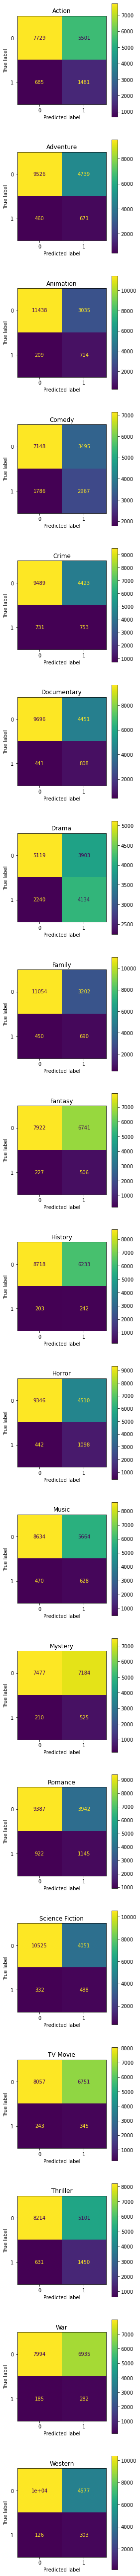

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=19, figsize=(4, 19*5))

for index, cm in enumerate(cms):
    ConfusionMatrixDisplay(cm).plot(ax=axs[index])
    axs[index].set_title(genre_list[index])

plt.show()

In [ ]:
for index in range(19):
    acc_score = accuracy_score(y_true[:,index], yhat_best[:,index])
    print(f"Accuracy [{genre_list[index]}] = {acc_score:.2%}")

Accuracy [Action] = 59.82%
Accuracy [Adventure] = 66.23%
Accuracy [Animation] = 78.93%
Accuracy [Comedy] = 65.70%
Accuracy [Crime] = 66.52%
Accuracy [Documentary] = 68.23%
Accuracy [Drama] = 60.10%
Accuracy [Family] = 76.28%
Accuracy [Fantasy] = 54.74%
Accuracy [History] = 58.20%
Accuracy [Horror] = 67.84%
Accuracy [Music] = 60.16%
Accuracy [Mystery] = 51.97%
Accuracy [Romance] = 68.41%
Accuracy [Science Fiction] = 71.53%
Accuracy [TV Movie] = 54.57%
Accuracy [Thriller] = 62.77%
Accuracy [War] = 53.75%
Accuracy [Western] = 69.45%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=77c65b12-8f22-428f-bb74-cd3ec355da56' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>